In [1]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

#####################################################
# This is almost identical to simple demonstration 
# -- except covariates have a skewed covariance matrix
#
# In this notebook, we train a 3-layer linear transformer with
# - context-length 20
# - covariate dimension 5, standard Gaussian distribution
# We plot
# - test loss against number of iterations
# - imshow of each parameter matrix at end of training
# - distance-to-identity of each parameter matrix
#####################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log' 
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [12]:
# Set up problem parameters

lr = 0.1
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 3  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 1  # 1-headed attention
B = 20000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 100000  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

In [21]:
filename_format = '/rotation_hist_adam_lowvar_long_{}_{}_{}.pth'
filename = filename_format.format(n_layer, N, d)
filename = (cur_dir + filename)
hist_dict = {}
U_dict = {}
D_dict = {}

seeds = [0,1,2] #for demonstration purpose, just use 3 seeds
keys = [(s,) for s in seeds]
for key in keys:
    sd = key[0]
    
    prob_seed = sd
    opt_seed = sd
    
    hist_dict[key] = []
    
    #set seed and initialize model
    torch.manual_seed(opt_seed)
    
    model = Transformer_F(n_layer, 1, d, var)
    model.to(device)
    #initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.99, 0.9), weight_decay=0)
    
    # set seed
    # sample random rotation matrix
    # initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    gaus = torch.FloatTensor(5,5).uniform_(-1,1).cuda()
    U = torch.linalg.svd (gaus)[0].cuda()
    D = torch.diag(torch.FloatTensor([1,1,1/2,1/4,1])).cuda()
    U_dict[key]=U
    D_dict[key]=D
    Z, y = generate_data(mode,N,d,B,shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)
    for t in range(max_iters):
        if t%4000==0 and t>1:# and t < 200001:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] *0.5
        if t%100==0:
            Z,y = generate_data_inplace(Z, shape_k=0.1, U=U, D=D)
        #if t==6000:
        #    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] *0.2
        #if t==12000:
        #    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] *0.2
        #if t==16000:
        #    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] *0.2
        start = time.time()
        # save model parameters
        if t%stride ==0:
            hist_dict[key].append(model.allparam.clone().detach())
        loss = in_context_loss(model, Z, y)
        # compute gradient, take step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()

        end=time.time()
        if t%100 ==0 or t<5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t,loss.item(), end-start, norms))
    #save to 
#torch.save({'hist_dict':hist_dict, 'U_dict':U_dict, 'D_dict':D_dict}, filename)

iter 0 | Loss: 4.910486698150635  time: 0.015358209609985352  gradnorm: 3.394021987915039
iter 1 | Loss: 3.199805498123169  time: 0.01574254035949707  gradnorm: 1.2850703001022339
iter 2 | Loss: 2.5423316955566406  time: 0.015639066696166992  gradnorm: 0.5540475845336914
iter 3 | Loss: 3.2930843830108643  time: 0.015643835067749023  gradnorm: 3.9975497722625732
iter 4 | Loss: 6.5552449226379395  time: 0.015669584274291992  gradnorm: 12.638612747192383
iter 100 | Loss: 0.4482348561286926  time: 0.013410568237304688  gradnorm: 0.1171441525220871
iter 200 | Loss: 0.24613803625106812  time: 0.013542890548706055  gradnorm: 0.06235988810658455
iter 300 | Loss: 0.1435708999633789  time: 0.013866662979125977  gradnorm: 0.027409054338932037
iter 400 | Loss: 0.04846780374646187  time: 0.013485193252563477  gradnorm: 0.012769542634487152
iter 500 | Loss: 0.044813208281993866  time: 0.013585329055786133  gradnorm: 0.010237009264528751
iter 600 | Loss: 0.025080641731619835  time: 0.0134923458099365

iter 7900 | Loss: 0.0007282290025614202  time: 0.01359248161315918  gradnorm: 7.089456630637869e-05
iter 8000 | Loss: 0.0008479768293909729  time: 0.013703346252441406  gradnorm: 6.192939326865599e-05
iter 8100 | Loss: 0.0007869923138059676  time: 0.013515710830688477  gradnorm: 6.935140118002892e-05
iter 8200 | Loss: 0.0008252124534919858  time: 0.013575315475463867  gradnorm: 7.545109110651538e-05
iter 8300 | Loss: 0.000862143118865788  time: 0.013368368148803711  gradnorm: 7.991949678398669e-05
iter 8400 | Loss: 0.0008153282105922699  time: 0.013823270797729492  gradnorm: 9.047524508787319e-05
iter 8500 | Loss: 0.000769960111938417  time: 0.013517618179321289  gradnorm: 8.116930985124782e-05
iter 8600 | Loss: 0.0008197795832529664  time: 0.013520479202270508  gradnorm: 8.523629367118701e-05
iter 8700 | Loss: 0.0010917438194155693  time: 0.013264894485473633  gradnorm: 0.00012972622062079608
iter 8800 | Loss: 0.0009380332776345313  time: 0.013433694839477539  gradnorm: 8.156300464179

iter 16000 | Loss: 0.0008649366209283471  time: 0.013702154159545898  gradnorm: 0.0001005651502055116
iter 16100 | Loss: 0.0006736883078701794  time: 0.013591289520263672  gradnorm: 8.810707367956638e-05
iter 16200 | Loss: 0.0007794990669935942  time: 0.013368368148803711  gradnorm: 7.449855183949694e-05
iter 16300 | Loss: 0.0008168998756445944  time: 0.013367176055908203  gradnorm: 5.8991940022679046e-05
iter 16400 | Loss: 0.0007482222863472998  time: 0.013251543045043945  gradnorm: 9.464285540161654e-05
iter 16500 | Loss: 0.000683239777572453  time: 0.013331413269042969  gradnorm: 9.257574856746942e-05
iter 16600 | Loss: 0.000827520911116153  time: 0.013781070709228516  gradnorm: 0.00012073239486198872
iter 16700 | Loss: 0.0008003076072782278  time: 0.013525009155273438  gradnorm: 0.00011507366434670985
iter 16800 | Loss: 0.000781570968683809  time: 0.013365745544433594  gradnorm: 6.66454216116108e-05
iter 16900 | Loss: 0.0008346066460944712  time: 0.013547182083129883  gradnorm: 0.0

iter 24100 | Loss: 0.0008010164019651711  time: 0.01352238655090332  gradnorm: 9.101738396566361e-05
iter 24200 | Loss: 0.0008505939040333033  time: 0.013652324676513672  gradnorm: 0.00018802373961079866
iter 24300 | Loss: 0.0006843842566013336  time: 0.013666391372680664  gradnorm: 0.0001408056850777939
iter 24400 | Loss: 0.0006967065273784101  time: 0.013362646102905273  gradnorm: 0.00012508680811151862
iter 24500 | Loss: 0.0007278494886122644  time: 0.01338338851928711  gradnorm: 0.00015157142479438335
iter 24600 | Loss: 0.0008347851689904928  time: 0.013427972793579102  gradnorm: 0.00010524408571654931
iter 24700 | Loss: 0.0008748467080295086  time: 0.013348102569580078  gradnorm: 0.00012855888053309172
iter 24800 | Loss: 0.0006856261752545834  time: 0.013673543930053711  gradnorm: 0.0001740102015901357
iter 24900 | Loss: 0.0009700738592073321  time: 0.013628959655761719  gradnorm: 0.0001752026000758633
iter 25000 | Loss: 0.0008460135431960225  time: 0.013867855072021484  gradnorm:

iter 32200 | Loss: 0.0006633472512476146  time: 0.013443470001220703  gradnorm: 8.053117926465347e-05
iter 32300 | Loss: 0.0006761946715414524  time: 0.013569116592407227  gradnorm: 7.55621149437502e-05
iter 32400 | Loss: 0.0007631233311258256  time: 0.013705730438232422  gradnorm: 7.403949712170288e-05
iter 32500 | Loss: 0.0006666441913694143  time: 0.013668298721313477  gradnorm: 9.207308903569356e-05
iter 32600 | Loss: 0.0007293454254977405  time: 0.013555288314819336  gradnorm: 7.104785618139431e-05
iter 32700 | Loss: 0.0010817124275490642  time: 0.013358592987060547  gradnorm: 7.997201464604586e-05
iter 32800 | Loss: 0.0007216837839223444  time: 0.013714075088500977  gradnorm: 8.642800821689889e-05
iter 32900 | Loss: 0.0007703729206696153  time: 0.013514518737792969  gradnorm: 7.081333751557395e-05
iter 33000 | Loss: 0.0006981678889133036  time: 0.013474225997924805  gradnorm: 9.739427332533523e-05
iter 33100 | Loss: 0.0007350730011239648  time: 0.013758420944213867  gradnorm: 0.0

iter 40300 | Loss: 0.0007239095284603536  time: 0.013459205627441406  gradnorm: 4.3821652070619166e-05
iter 40400 | Loss: 0.000788824341725558  time: 0.01372385025024414  gradnorm: 5.566709296545014e-05
iter 40500 | Loss: 0.0007127815042622387  time: 0.013664960861206055  gradnorm: 6.13498268648982e-05
iter 40600 | Loss: 0.0006915030535310507  time: 0.013687372207641602  gradnorm: 4.805754724657163e-05
iter 40700 | Loss: 0.0006016668048687279  time: 0.013399600982666016  gradnorm: 3.263296821387485e-05
iter 40800 | Loss: 0.0007371954852715135  time: 0.013266801834106445  gradnorm: 7.549125439254567e-05
iter 40900 | Loss: 0.0006764961290173233  time: 0.013815641403198242  gradnorm: 4.773932960233651e-05
iter 41000 | Loss: 0.0007298890850506723  time: 0.013447284698486328  gradnorm: 6.321857654256746e-05
iter 41100 | Loss: 0.0006993230199441314  time: 0.013759613037109375  gradnorm: 6.468222272815183e-05
iter 41200 | Loss: 0.0007624054560437799  time: 0.013488054275512695  gradnorm: 7.19

iter 48400 | Loss: 0.0006723605911247432  time: 0.013259649276733398  gradnorm: 4.3477804865688086e-05
iter 48500 | Loss: 0.0006814619991928339  time: 0.01382303237915039  gradnorm: 2.9855700631742366e-05
iter 48600 | Loss: 0.0008332245633937418  time: 0.013369560241699219  gradnorm: 6.290188321145251e-05
iter 48700 | Loss: 0.0006157010793685913  time: 0.01372981071472168  gradnorm: 6.715462950523943e-05
iter 48800 | Loss: 0.0007137427455745637  time: 0.013760805130004883  gradnorm: 3.7601497751893476e-05
iter 48900 | Loss: 0.0007027899846434593  time: 0.013886451721191406  gradnorm: 6.543895142385736e-05
iter 49000 | Loss: 0.0007185968570411205  time: 0.013790369033813477  gradnorm: 3.820339770754799e-05
iter 49100 | Loss: 0.0006415454554371536  time: 0.01340937614440918  gradnorm: 3.7187837733654305e-05
iter 49200 | Loss: 0.0006224153330549598  time: 0.013388872146606445  gradnorm: 4.719448770629242e-05
iter 49300 | Loss: 0.0006496095447801054  time: 0.013628005981445312  gradnorm: 4

iter 56500 | Loss: 0.0006281545502133667  time: 0.013518810272216797  gradnorm: 4.824580901185982e-05
iter 56600 | Loss: 0.0006340004038065672  time: 0.013352155685424805  gradnorm: 6.552876584464684e-05
iter 56700 | Loss: 0.0006923862965777516  time: 0.013793468475341797  gradnorm: 4.544588955468498e-05
iter 56800 | Loss: 0.0006698481156490743  time: 0.013391494750976562  gradnorm: 3.930076491087675e-05
iter 56900 | Loss: 0.0006151288980618119  time: 0.013413667678833008  gradnorm: 2.636482531670481e-05
iter 57000 | Loss: 0.0008926284499466419  time: 0.013705253601074219  gradnorm: 9.4299488409888e-05
iter 57100 | Loss: 0.0007961808005347848  time: 0.013546228408813477  gradnorm: 5.2205017709638923e-05
iter 57200 | Loss: 0.0006095669814385474  time: 0.013563156127929688  gradnorm: 3.956931323045865e-05
iter 57300 | Loss: 0.0007864290964789689  time: 0.013683557510375977  gradnorm: 5.392875027609989e-05
iter 57400 | Loss: 0.0008376060286536813  time: 0.013684749603271484  gradnorm: 6.5

iter 64600 | Loss: 0.000620269391220063  time: 0.013358354568481445  gradnorm: 2.5770452339202166e-05
iter 64700 | Loss: 0.0007055019377730787  time: 0.013707876205444336  gradnorm: 4.1861741920001805e-05
iter 64800 | Loss: 0.0006506812060251832  time: 0.013386964797973633  gradnorm: 4.0589187847217545e-05
iter 64900 | Loss: 0.0008822049130685627  time: 0.013374567031860352  gradnorm: 4.8074165533762425e-05
iter 65000 | Loss: 0.000697613344527781  time: 0.013560056686401367  gradnorm: 2.7520272851688787e-05
iter 65100 | Loss: 0.0007521699881181121  time: 0.013361215591430664  gradnorm: 3.474713594187051e-05
iter 65200 | Loss: 0.0006595870945602655  time: 0.013574600219726562  gradnorm: 2.5127910703304224e-05
iter 65300 | Loss: 0.0006346847512759268  time: 0.013509750366210938  gradnorm: 2.4541495804442093e-05
iter 65400 | Loss: 0.0006727729341946542  time: 0.013578176498413086  gradnorm: 3.43722385878209e-05
iter 65500 | Loss: 0.0006157276220619678  time: 0.013881921768188477  gradnorm

iter 72700 | Loss: 0.000620545819401741  time: 0.013641119003295898  gradnorm: 3.2618561817798764e-05
iter 72800 | Loss: 0.0007128763827495277  time: 0.013342142105102539  gradnorm: 3.722444671439007e-05
iter 72900 | Loss: 0.0006137032760307193  time: 0.013745307922363281  gradnorm: 3.8254205719567835e-05
iter 73000 | Loss: 0.0005336686153896153  time: 0.013532638549804688  gradnorm: 2.872352342819795e-05
iter 73100 | Loss: 0.0006102967308834195  time: 0.013783693313598633  gradnorm: 3.2521264074603096e-05
iter 73200 | Loss: 0.0007872396963648498  time: 0.013637304306030273  gradnorm: 3.5277564165880904e-05
iter 73300 | Loss: 0.0006762302364222705  time: 0.013592243194580078  gradnorm: 2.126078834407963e-05
iter 73400 | Loss: 0.0006626686663366854  time: 0.013633012771606445  gradnorm: 4.436517701833509e-05
iter 73500 | Loss: 0.0007034267182461917  time: 0.01372528076171875  gradnorm: 4.016684397356585e-05
iter 73600 | Loss: 0.0006312516052275896  time: 0.013896942138671875  gradnorm: 

iter 80800 | Loss: 0.0005983632290735841  time: 0.013428449630737305  gradnorm: 3.6643006751546636e-05
iter 80900 | Loss: 0.0007030588458292186  time: 0.01355433464050293  gradnorm: 3.577089955797419e-05
iter 81000 | Loss: 0.0006432192749343812  time: 0.013582944869995117  gradnorm: 2.8851214665337466e-05
iter 81100 | Loss: 0.000622449500951916  time: 0.013518571853637695  gradnorm: 2.5448680389672518e-05
iter 81200 | Loss: 0.0005968048935756087  time: 0.013463258743286133  gradnorm: 5.0531096349004656e-05
iter 81300 | Loss: 0.0005530844791792333  time: 0.013415813446044922  gradnorm: 2.5681911210995167e-05
iter 81400 | Loss: 0.000673637492582202  time: 0.013565301895141602  gradnorm: 3.4699445677688345e-05
iter 81500 | Loss: 0.000618109421338886  time: 0.013686656951904297  gradnorm: 3.578299219952896e-05
iter 81600 | Loss: 0.0006256118649616838  time: 0.013390302658081055  gradnorm: 3.1538867915514857e-05
iter 81700 | Loss: 0.0006470883381552994  time: 0.013822555541992188  gradnorm:

iter 88900 | Loss: 0.000842127192299813  time: 0.013751745223999023  gradnorm: 4.005618393421173e-05
iter 89000 | Loss: 0.0006117006996646523  time: 0.013376235961914062  gradnorm: 2.027418668149039e-05
iter 89100 | Loss: 0.0006780619733035564  time: 0.013387441635131836  gradnorm: 4.877939136349596e-05
iter 89200 | Loss: 0.0006088448571972549  time: 0.013674497604370117  gradnorm: 3.064839620492421e-05
iter 89300 | Loss: 0.0007456070161424577  time: 0.013605117797851562  gradnorm: 4.7533925680909306e-05
iter 89400 | Loss: 0.000767015153542161  time: 0.013434886932373047  gradnorm: 4.5474993385141715e-05
iter 89500 | Loss: 0.0005984330200590193  time: 0.013741493225097656  gradnorm: 2.506646342226304e-05
iter 89600 | Loss: 0.0007171190809458494  time: 0.013379573822021484  gradnorm: 2.123319609381724e-05
iter 89700 | Loss: 0.0006272520986385643  time: 0.01378774642944336  gradnorm: 3.378043038537726e-05
iter 89800 | Loss: 0.000688582134898752  time: 0.01348567008972168  gradnorm: 4.262

iter 97000 | Loss: 0.0006616928149014711  time: 0.013638734817504883  gradnorm: 2.2533238734467886e-05
iter 97100 | Loss: 0.0006596491439267993  time: 0.01333928108215332  gradnorm: 3.827460022876039e-05
iter 97200 | Loss: 0.0006418026750907302  time: 0.013559579849243164  gradnorm: 2.7697924451786093e-05
iter 97300 | Loss: 0.0005896505899727345  time: 0.013737678527832031  gradnorm: 2.2415004423237406e-05
iter 97400 | Loss: 0.0006667610723525286  time: 0.01362919807434082  gradnorm: 3.7992656871210784e-05
iter 97500 | Loss: 0.0006326118018478155  time: 0.013579845428466797  gradnorm: 3.01288855553139e-05
iter 97600 | Loss: 0.0006482450990006328  time: 0.013808488845825195  gradnorm: 3.8346795918187127e-05
iter 97700 | Loss: 0.0005927274469286203  time: 0.013413667678833008  gradnorm: 2.5639814339228906e-05
iter 97800 | Loss: 0.0007392624393105507  time: 0.014236688613891602  gradnorm: 4.916275429422967e-05
iter 97900 | Loss: 0.0006347597227431834  time: 0.013805866241455078  gradnorm:

iter 4800 | Loss: 0.0007602230762131512  time: 0.013815641403198242  gradnorm: 5.882375262444839e-05
iter 4900 | Loss: 0.0007400301983579993  time: 0.013368606567382812  gradnorm: 6.553681305376813e-05
iter 5000 | Loss: 0.0009686639532446861  time: 0.013674736022949219  gradnorm: 0.00010250243212794885
iter 5100 | Loss: 0.0010657717939466238  time: 0.01345968246459961  gradnorm: 0.00012686796253547072
iter 5200 | Loss: 0.0008024361450225115  time: 0.01375126838684082  gradnorm: 0.00011733779683709145
iter 5300 | Loss: 0.0007885942468419671  time: 0.01345062255859375  gradnorm: 0.00010399463644716889
iter 5400 | Loss: 0.0008506202721036971  time: 0.013605833053588867  gradnorm: 0.00011820799409179017
iter 5500 | Loss: 0.0007230046903714538  time: 0.01370549201965332  gradnorm: 7.844415085855871e-05
iter 5600 | Loss: 0.0007535225013270974  time: 0.013402700424194336  gradnorm: 6.553539424203336e-05
iter 5700 | Loss: 0.0008916060323826969  time: 0.013465166091918945  gradnorm: 9.702282113

iter 12900 | Loss: 0.0006521856994368136  time: 0.01339578628540039  gradnorm: 6.508248770842329e-05
iter 13000 | Loss: 0.0008655311539769173  time: 0.013567209243774414  gradnorm: 9.509589290246367e-05
iter 13100 | Loss: 0.0007842383347451687  time: 0.013510704040527344  gradnorm: 6.93763213348575e-05
iter 13200 | Loss: 0.0008504860452376306  time: 0.013298988342285156  gradnorm: 0.00010142541577806696
iter 13300 | Loss: 0.0008616987033747137  time: 0.013635873794555664  gradnorm: 7.713207742199302e-05
iter 13400 | Loss: 0.0008896311628632247  time: 0.013677120208740234  gradnorm: 6.872644007671624e-05
iter 13500 | Loss: 0.0009293202892877162  time: 0.013134479522705078  gradnorm: 7.391519466182217e-05
iter 13600 | Loss: 0.0008350236457772553  time: 0.01371145248413086  gradnorm: 8.0447418440599e-05
iter 13700 | Loss: 0.0008932306081987917  time: 0.013547420501708984  gradnorm: 8.842121314955875e-05
iter 13800 | Loss: 0.031937289983034134  time: 0.013611555099487305  gradnorm: 0.00442

iter 21000 | Loss: 0.000771061226259917  time: 0.013567447662353516  gradnorm: 0.00012239007628522813
iter 21100 | Loss: 0.000767619872931391  time: 0.013510465621948242  gradnorm: 5.521931598195806e-05
iter 21200 | Loss: 0.0007248473120853305  time: 0.013630390167236328  gradnorm: 0.0001795796415535733
iter 21300 | Loss: 0.0007709264755249023  time: 0.013683080673217773  gradnorm: 0.00015969118976499885
iter 21400 | Loss: 0.00072045176057145  time: 0.013928890228271484  gradnorm: 0.00010480357013875619
iter 21500 | Loss: 0.0007461298955604434  time: 0.013531684875488281  gradnorm: 0.00014378955529537052
iter 21600 | Loss: 0.0007402267074212432  time: 0.013386964797973633  gradnorm: 9.783920540940017e-05
iter 21700 | Loss: 0.0009873711969703436  time: 0.013520479202270508  gradnorm: 0.00013102040975354612
iter 21800 | Loss: 0.0009462127345614135  time: 0.013705015182495117  gradnorm: 0.00010315102554159239
iter 21900 | Loss: 0.0008627763600088656  time: 0.013559818267822266  gradnorm: 

iter 29100 | Loss: 0.0007193733472377062  time: 0.013312816619873047  gradnorm: 8.899094245862216e-05
iter 29200 | Loss: 0.0007163021364249289  time: 0.01336812973022461  gradnorm: 7.801609899615869e-05
iter 29300 | Loss: 0.0006678439094685018  time: 0.013824939727783203  gradnorm: 0.00010051363642560318
iter 29400 | Loss: 0.000711894768755883  time: 0.01333165168762207  gradnorm: 8.01647620392032e-05
iter 29500 | Loss: 0.0006993927527219057  time: 0.013780593872070312  gradnorm: 0.00010184801067225635
iter 29600 | Loss: 0.0007409092504531145  time: 0.013578414916992188  gradnorm: 0.0001320630981354043
iter 29700 | Loss: 0.0006411257782019675  time: 0.01353144645690918  gradnorm: 6.525528442580253e-05
iter 29800 | Loss: 0.0008108934271149337  time: 0.013706207275390625  gradnorm: 0.00010505646787350997
iter 29900 | Loss: 0.0006809505866840482  time: 0.01337575912475586  gradnorm: 9.554960706736892e-05
iter 30000 | Loss: 0.0008978078840300441  time: 0.013382434844970703  gradnorm: 0.000

iter 37200 | Loss: 0.0007785802008584142  time: 0.013372659683227539  gradnorm: 6.28685302217491e-05
iter 37300 | Loss: 0.0005971738719381392  time: 0.013419151306152344  gradnorm: 3.9920018025441095e-05
iter 37400 | Loss: 0.0007209635805338621  time: 0.01355123519897461  gradnorm: 4.133377660764381e-05
iter 37500 | Loss: 0.0006794658838771284  time: 0.01353001594543457  gradnorm: 5.2997111197328195e-05
iter 37600 | Loss: 0.0007760318694636226  time: 0.013589143753051758  gradnorm: 5.470424730447121e-05
iter 37700 | Loss: 0.0007197349332273006  time: 0.01335287094116211  gradnorm: 5.7142948207911104e-05
iter 37800 | Loss: 0.0006877389387227595  time: 0.013402700424194336  gradnorm: 4.9398346163798124e-05
iter 37900 | Loss: 0.00068583560641855  time: 0.013504505157470703  gradnorm: 5.5481763411080465e-05
iter 38000 | Loss: 0.0007098742062225938  time: 0.013826370239257812  gradnorm: 6.249096622923389e-05
iter 38100 | Loss: 0.0007423985516652465  time: 0.01386117935180664  gradnorm: 6.74

iter 45300 | Loss: 0.0006560825859196484  time: 0.013665199279785156  gradnorm: 3.5700402804650366e-05
iter 45400 | Loss: 0.0007006043451838195  time: 0.013318538665771484  gradnorm: 6.570149707840756e-05
iter 45500 | Loss: 0.0006430067587643862  time: 0.013768672943115234  gradnorm: 3.361005292390473e-05
iter 45600 | Loss: 0.0006929429364390671  time: 0.013314247131347656  gradnorm: 5.188708382775076e-05
iter 45700 | Loss: 0.0006637856131419539  time: 0.013675689697265625  gradnorm: 7.058173650875688e-05
iter 45800 | Loss: 0.0006592784775421023  time: 0.01318979263305664  gradnorm: 4.922487278236076e-05
iter 45900 | Loss: 0.0007302677258849144  time: 0.013624191284179688  gradnorm: 4.927049303660169e-05
iter 46000 | Loss: 0.0006187696126289666  time: 0.013360738754272461  gradnorm: 4.9867718189489096e-05
iter 46100 | Loss: 0.0006187994731590152  time: 0.013638973236083984  gradnorm: 4.347954745753668e-05
iter 46200 | Loss: 0.0006349094328470528  time: 0.013602733612060547  gradnorm: 3

iter 53400 | Loss: 0.0006232630694285035  time: 0.01335453987121582  gradnorm: 3.8924765249248594e-05
iter 53500 | Loss: 0.0005911613116040826  time: 0.01351618766784668  gradnorm: 4.146890569245443e-05
iter 53600 | Loss: 0.000781508453655988  time: 0.013453483581542969  gradnorm: 4.938379424856976e-05
iter 53700 | Loss: 0.0007195805083028972  time: 0.013724565505981445  gradnorm: 4.561472815112211e-05
iter 53800 | Loss: 0.0005481019616127014  time: 0.013670206069946289  gradnorm: 4.230997001286596e-05
iter 53900 | Loss: 0.0007014474831521511  time: 0.013438224792480469  gradnorm: 5.516563760465942e-05
iter 54000 | Loss: 0.0006166365346871316  time: 0.013561248779296875  gradnorm: 3.7842346500838175e-05
iter 54100 | Loss: 0.0006636297912336886  time: 0.013370275497436523  gradnorm: 2.566399962233845e-05
iter 54200 | Loss: 0.0006525579374283552  time: 0.013834953308105469  gradnorm: 3.5806795494863763e-05
iter 54300 | Loss: 0.0006407953915186226  time: 0.013396024703979492  gradnorm: 5.

iter 61500 | Loss: 0.0006871643709018826  time: 0.013721227645874023  gradnorm: 3.439968713792041e-05
iter 61600 | Loss: 0.0006551107508130372  time: 0.013399839401245117  gradnorm: 3.74739793187473e-05
iter 61700 | Loss: 0.0005869045853614807  time: 0.013477563858032227  gradnorm: 2.7448602850199677e-05
iter 61800 | Loss: 0.0006225673132576048  time: 0.013689756393432617  gradnorm: 2.248897908430081e-05
iter 61900 | Loss: 0.0007225776789709926  time: 0.01331949234008789  gradnorm: 3.3635791623964906e-05
iter 62000 | Loss: 0.0006770268664695323  time: 0.013589620590209961  gradnorm: 4.282661757315509e-05
iter 62100 | Loss: 0.0008147451444528997  time: 0.013491392135620117  gradnorm: 4.9209622375201434e-05
iter 62200 | Loss: 0.0006158826290629804  time: 0.013600826263427734  gradnorm: 2.838971522578504e-05
iter 62300 | Loss: 0.0006057231803424656  time: 0.013899803161621094  gradnorm: 4.3301242840243503e-05
iter 62400 | Loss: 0.0008462201803922653  time: 0.013398885726928711  gradnorm: 

iter 69600 | Loss: 0.0006754376227036119  time: 0.013956546783447266  gradnorm: 3.2191426726058125e-05
iter 69700 | Loss: 0.0005809926078654826  time: 0.013785362243652344  gradnorm: 3.07049231196288e-05
iter 69800 | Loss: 0.0006136479205451906  time: 0.013307571411132812  gradnorm: 3.495738565106876e-05
iter 69900 | Loss: 0.0007265303283929825  time: 0.013725519180297852  gradnorm: 5.171315933694132e-05
iter 70000 | Loss: 0.0006569122197106481  time: 0.013497591018676758  gradnorm: 4.65302073280327e-05
iter 70100 | Loss: 0.000820113520603627  time: 0.01343989372253418  gradnorm: 3.877983908751048e-05
iter 70200 | Loss: 0.0006932323449291289  time: 0.013894081115722656  gradnorm: 2.223671253887005e-05
iter 70300 | Loss: 0.0009148481185548007  time: 0.013291120529174805  gradnorm: 4.3221520172664896e-05
iter 70400 | Loss: 0.0006428193300962448  time: 0.013631582260131836  gradnorm: 2.586826121842023e-05
iter 70500 | Loss: 0.000612358096987009  time: 0.013402223587036133  gradnorm: 2.622

iter 77700 | Loss: 0.0006112784030847251  time: 0.013292312622070312  gradnorm: 3.303561607026495e-05
iter 77800 | Loss: 0.0006144270882941782  time: 0.013652801513671875  gradnorm: 2.037788181041833e-05
iter 77900 | Loss: 0.0006222090451046824  time: 0.013457536697387695  gradnorm: 2.430671884212643e-05
iter 78000 | Loss: 0.000688776548486203  time: 0.0138397216796875  gradnorm: 4.4487405830295756e-05
iter 78100 | Loss: 0.0008602769812569022  time: 0.013480186462402344  gradnorm: 4.6971959818620235e-05
iter 78200 | Loss: 0.0006147627718746662  time: 0.013761043548583984  gradnorm: 3.4484666684875265e-05
iter 78300 | Loss: 0.0007912482833489776  time: 0.013469457626342773  gradnorm: 5.934795626671985e-05
iter 78400 | Loss: 0.0006514007691293955  time: 0.013656854629516602  gradnorm: 3.370163176441565e-05
iter 78500 | Loss: 0.0006765848374925554  time: 0.01348876953125  gradnorm: 4.163160338066518e-05
iter 78600 | Loss: 0.0006989565445110202  time: 0.013478279113769531  gradnorm: 5.2226

iter 85800 | Loss: 0.000681262114085257  time: 0.013349056243896484  gradnorm: 1.8555398128228262e-05
iter 85900 | Loss: 0.0006548913079313934  time: 0.013386964797973633  gradnorm: 2.6323010388296098e-05
iter 86000 | Loss: 0.0006112646660767496  time: 0.013332128524780273  gradnorm: 3.179491250193678e-05
iter 86100 | Loss: 0.0006841606227681041  time: 0.013639211654663086  gradnorm: 3.43721876561176e-05
iter 86200 | Loss: 0.0006453825626522303  time: 0.01380300521850586  gradnorm: 4.616454316419549e-05
iter 86300 | Loss: 0.0005695082363672554  time: 0.013950347900390625  gradnorm: 4.4891872676089406e-05
iter 86400 | Loss: 0.0009029348148033023  time: 0.013427019119262695  gradnorm: 5.5867491028038785e-05
iter 86500 | Loss: 0.0005990131176076829  time: 0.013644933700561523  gradnorm: 3.726468639797531e-05
iter 86600 | Loss: 0.0008305454975925386  time: 0.013431072235107422  gradnorm: 3.5183307772967964e-05
iter 86700 | Loss: 0.0006619109772145748  time: 0.013765811920166016  gradnorm: 

iter 93900 | Loss: 0.0005629326915368438  time: 0.01349496841430664  gradnorm: 3.4803331800503656e-05
iter 94000 | Loss: 0.0005954967346042395  time: 0.013180732727050781  gradnorm: 3.204859240213409e-05
iter 94100 | Loss: 0.0006714520859532058  time: 0.013895988464355469  gradnorm: 4.29037754656747e-05
iter 94200 | Loss: 0.0007282643346115947  time: 0.01363372802734375  gradnorm: 3.4940956538775936e-05
iter 94300 | Loss: 0.0006446221959777176  time: 0.013638019561767578  gradnorm: 4.1330669773742557e-05
iter 94400 | Loss: 0.0008260715403594077  time: 0.013658523559570312  gradnorm: 6.880988803459331e-05
iter 94500 | Loss: 0.0006741228862665594  time: 0.01340031623840332  gradnorm: 3.1739225960336626e-05
iter 94600 | Loss: 0.0007533651660196483  time: 0.013542413711547852  gradnorm: 4.765876292367466e-05
iter 94700 | Loss: 0.0006837576511316001  time: 0.014133453369140625  gradnorm: 3.95128590753302e-05
iter 94800 | Loss: 0.0006491169333457947  time: 0.013550281524658203  gradnorm: 4.6

In [23]:
seeds=[0,1,2]

In [24]:
####################################
# compute test loss
####################################
#hist_dict = torch.load(filename)['hist_dict']
loss_dict = {}
for key in hist_dict:
    sd = key[0]
    
    U = U_dict[key]
    D = D_dict[key]
    
    loss_dict[key] = torch.zeros(max_iters//stride)
    
    np.random.seed(99)
    torch.manual_seed(99)
    Z, y = generate_data(mode,N,d,B,shape_k,U,D)
    Z = Z.to(device)
    y = y.to(device)
    model = Transformer_F(n_layer, n_head, d, var).to(device)
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            model.allparam.copy_(hist_dict[key][t//stride])
        loss_dict[key][t//stride] = in_context_loss(model, Z, y).item()

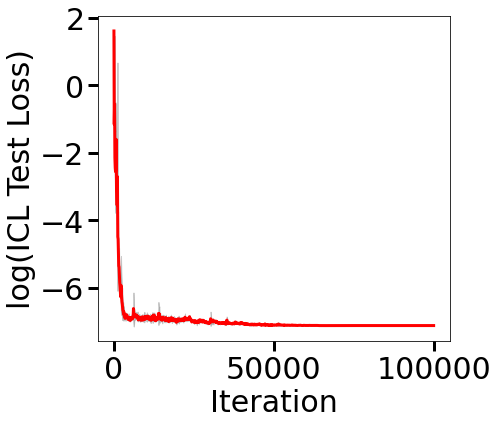

In [37]:
####################################
# plot the test loss with error bars
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (7, 6))

losses = torch.zeros(len(seeds), max_iters//stride)
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key].log()
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)
ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3)#, label='Adam')
ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std, losses_mean+losses_std, color = 'black', alpha = 0.2)
ax.set_xlabel('Iteration',fontsize=30)
ax.set_ylabel('log(ICL Test Loss)',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
#ax.legend(fontsize=30)
#ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/rotation_demonstration_adam_loss_plot.pdf', dpi=600)

In [26]:
print(losses_mean[-1])

tensor(-7.12)


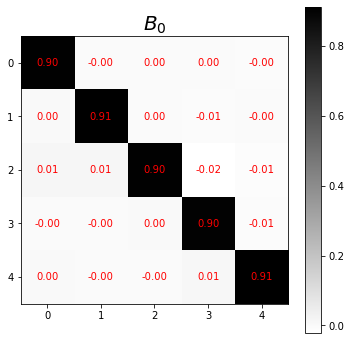

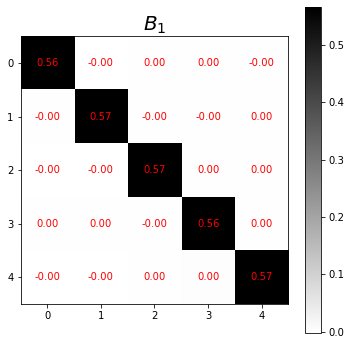

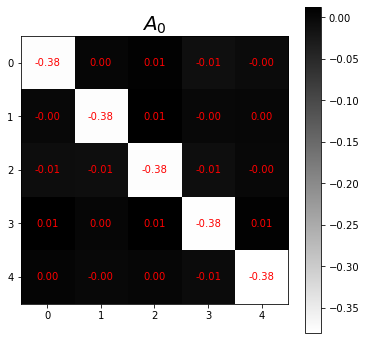

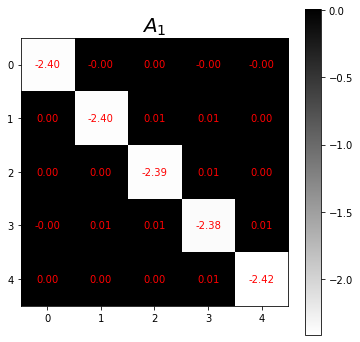

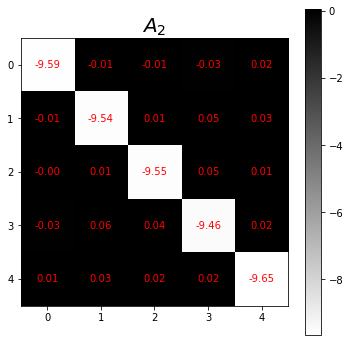

In [36]:
####################################
# display the parameter matrices
# image/font setting assumes d=5
####################################
s=0
key = (s,)
for l in range(n_layer-1):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][-1][l,h,0,:,:]
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$B_{}$'.format(l),fontsize=20)
        
        plt.savefig(fig_dir + '/rotation_demonstration_adam_B{}.pdf'.format(l), dpi=600)

U = U_dict[(s,)]
D = D_dict[(s,)]
UD = torch.mm(U,D)        
for l in range(n_layer):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][-1][l,h,1,:,:]
        #rotate matrix by inverse of UD
        matrix = torch.mm(torch.mm(UD.t(), matrix), UD)
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$A_{}$'.format(l),fontsize=20)
        plt.savefig(fig_dir + '/rotation_demonstration_adam_A{}.pdf'.format(l), dpi=600)
    

In [28]:
########################################################
# plot the distance-to-identity of each matrix with time
########################################################

# function for computing distance to identity
def compute_dist_identity(M):
    scale = torch.sum(torch.diagonal(M))/M.shape[0]
    ideal_identity = scale* torch.eye(M.shape[0]).to(device)
    difference = M - ideal_identity
    err = (torch.norm(difference,p='fro')/torch.norm(M,p='fro'))
    return err

########################################
# compute distances (assume n_head = 1)
########################################
dist_dict = {}
            
for key in hist_dict:
    (sd,) = key
    dist_dict[key] = torch.zeros(n_layer, 2, max_iters//stride)
    U = U_dict[key]
    D = D_dict[key]
    UD = torch.mm(U,D)        
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            allparam = hist_dict[key][t//stride]
        for i in range(n_layer):
            for j in range(2):
                matrix = allparam[i,0,j,:,:]
                if j ==1:
                    matrix = torch.mm(torch.mm(UD.t(), matrix), UD)
                dist_dict[key][i,j,t//stride] = compute_dist_identity(matrix).item()

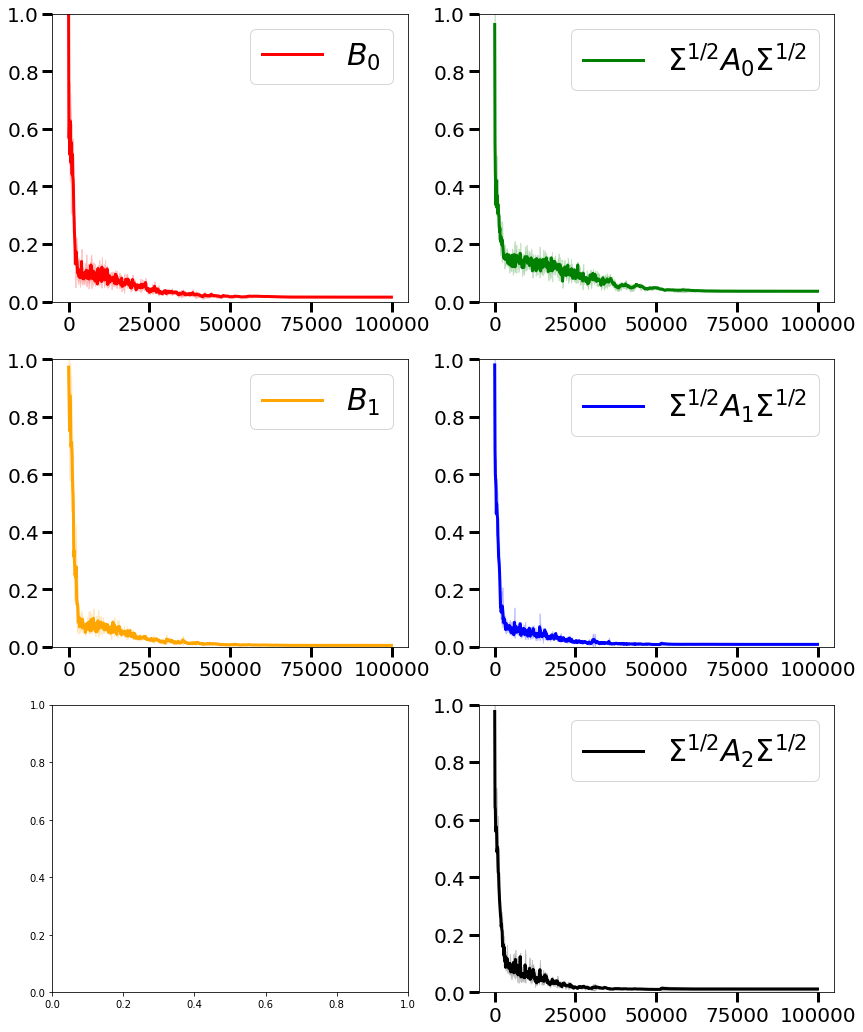

In [38]:

####################################
# plot distances
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, axs = plt.subplots(3, 2,figsize = (14, 18))

labels = ['$B_0$', '$B_1$', None, 
          '$\Sigma^{1/2} A_0 \Sigma^{1/2}$', 
          '$\Sigma^{1/2} A_1 \Sigma^{1/2}$', 
          '$\Sigma^{1/2} A_2 \Sigma^{1/2}$']
colors = ['red','orange',None, 'green','blue','black']

#make P plots
for l in range(n_layer):
    for pq in range(2):
        if l==n_layer-1 and pq==0:
            continue
        ax = axs[l,pq]
        dist_p = torch.zeros(len(seeds), max_iters//stride)
        for idx, sd in enumerate(seeds):
            losses[idx,:] = dist_dict[(sd,)][l,pq,:]
        dist_mean = torch.mean(losses, axis=0)
        dist_std = torch.std(losses, axis=0)
        
        style_id = l + 3*pq
        
        ax.plot(range(0,max_iters,stride), dist_mean, color = colors[style_id], lw = 3, label=labels[style_id])
        ax.fill_between(range(0,max_iters,stride), dist_mean-dist_std, dist_mean+dist_std, color = colors[style_id], alpha = 0.2)
        #ax.set_xlabel('Iteration',fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=20, width = 3, length = 10)
        ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
        ax.legend(fontsize=30)
        ax.set_ylim([0,1])
        
plt.savefig(fig_dir + '/rotation_demonstration_dist_to_id_adam.pdf', dpi=600)

